In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

### Global Variables

In [2]:
''' 

95 Percentile
BAC 1wk 7.16%, 1d 2.5%, 1hr 1%
CRM 1d 2.76%, 1hr 1%
IDEX 1d 10.8%, 1hr 4.15%
IYW 1d 1.5%, 1hr 0.697%
JEF 1d 2.5%, 1hr 1.1%
NVAX 1d 6.46%, 1hr 3.15%
QDEL 1d 3.53%, 1hr 
TSLA 1d 4.3%, 1hr 1.66%
VBIV 1d 7.99%, 1hr 4.05%
VGT 1d 1.41% 1hr 0.686%
VHT 1d 1.24%, 1hr 0.59%

'''

interval = '1d' # 60m or 1d or 1wk
history = '10y' # 2y for 60m, 10y for 1d, 25y or max for 1wk
perc_inc = 0.0276 # see percentages above
symbol = 'CRM'
perc_train = 0.25
load_new = 1 # 0 for reuse, 1 for load new from server
current = 0 # 0 for 2nd to last data point (once markets open), 1 for last data point (when market is closed)
loc = -1 # row for previous nth interval, -2 (once market open)

In [3]:
if interval == '1d' or interval == '1wk':
    index_col = 'Date'
else:
    index_col = 'Datetime'

In [4]:
stock_df = yf.download(tickers = symbol # symbol of stock 

                           , period = history # length of history back in time

                           , interval = interval # time periods of subinterval e.g. 1m or 1hr

                           # , start = start # start date, time

                           # , end = end # end date, time

                           , prepost = False # pre/post market data
                          )
stock_df.head(5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-09-07,29.754999,30.112499,29.712500,29.912500,29.912500,7971600
2010-09-08,30.107500,30.322500,29.785000,29.947500,29.947500,8782000
2010-09-09,30.490000,30.500000,29.312500,29.412500,29.412500,10284000
2010-09-10,29.627501,29.842501,29.127501,29.355000,29.355000,9489600
2010-09-13,29.717501,30.000000,29.225000,29.647499,29.647499,10162800


In [5]:
def direction(interval = interval
              , history = history
              , perc_inc = perc_inc
              , symbol = symbol
              , perc_train = perc_train
              , load_new = load_new 
              , current = current
              , loc = loc
             ):
    
    import pandas as pd
    import numpy as np

    import matplotlib.pyplot as plt
    plt.rcParams['font.size'] = 12
    plt.rcParams['figure.figsize'] = (8, 7)
    plt.style.use('fivethirtyeight')

    import warnings
    warnings.filterwarnings('ignore')

    import yfinance as yf

    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import (roc_auc_score
                                 , precision_score
                                 , recall_score
                                 , roc_curve
                                 , confusion_matrix
                                 , plot_confusion_matrix
                                 , precision_recall_curve
                                 , auc
                                )
    
    # Load New From Server
    if load_new == 1:
        stock_df = yf.download(tickers = symbol # symbol of stock 

                           , period = history # length of history back in time

                           , interval = interval # time periods of subinterval e.g. 1m or 1hr

                           # , start = start # start date, time

                           # , end = end # end date, time

                           , prepost = False # pre/post market data
                          )
        
        # Create Percent Change
        stock_df['percent change'] = (stock_df.Close - stock_df.Open) / stock_df.Open
        
        # Create High Low Difference
        stock_df['hl percent change'] = np.where(stock_df['percent change'] > 0
                                , (stock_df.High - stock_df.Low)/stock_df.Low
                                , (stock_df.Low - stock_df.High)/stock_df.High
                               )

        #create decision column
        stock_df['decision'] = np.where((stock_df['Close'] - stock_df['Open'])/stock_df['Open'] > perc_inc

                                        , 1  # 1 if up % or greater

                                        , 0  # 0 if not up % or greater

                                       )
        # Create one offs
        decisions = stock_df.decision.values
        decisions = decisions[1:len(decisions)]
        stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1]
        stock_df_one_off['decision'] = decisions
        
        # Drop NaN
        stock_df.dropna(axis=0
                        , inplace = True
                       )

        # Save DF to CSV
        stock_df.to_csv('stock_df.csv')
        
    else:
        if interval == '1d' or interval == '1wk':
            index_col = 'Date'
        else:
            index_col = 'Datetime'
   
        stock_df = pd.read_csv('stock_df.csv', index_col=index_col)
    
        # create one offs
        decisions = stock_df.decision.values
        decisions = decisions[1:len(decisions)]
        stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1]
        stock_df_one_off['decision'] = decisions
 
    # balance the data
    ones = stock_df_one_off.decision.value_counts()[1]
    stock_df_bal = stock_df_one_off.groupby('decision').apply(lambda x: x.sample(n=ones)).reset_index(drop=True)
    
    # check for NaN's
    stock_df_bal.dropna(axis=0, inplace=True)
    
    # Train Test Split
    X = stock_df_bal.drop(columns=['decision']) # get columns other than decision
    y = stock_df_bal['decision'] # get decision column
    
    X_train, X_test, y_train, y_test = train_test_split(X
                                                        , y
                                                        , test_size=0.20
                                                        , random_state = 42
                                                       )

    #random forest classifier rfc
    if symbol == 'BAC' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 2
                                     , max_features = 1
                                     , min_samples_leaf = 5
                                     , min_samples_split = 5
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'BAC' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 4
                                     , max_features = 4
                                     , min_samples_leaf = 2
                                     , min_samples_split = 5
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )

    elif symbol == 'CRM' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 3
                                     , max_features = 5
                                     , min_samples_leaf = 5
                                     , min_samples_split = 2
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'CRM' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 6
                                     , max_features = 2
                                     , min_samples_leaf = 1
                                     , min_samples_split = 3
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
    
    elif symbol == 'IDEX' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = False
                                     , max_depth = 4
                                     , max_features = 6
                                     , min_samples_leaf = 1
                                     , min_samples_split = 2
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'IDEX' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 5
                                     , max_features = 3
                                     , min_samples_leaf = 2
                                     , min_samples_split = 4
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
    
    elif symbol == 'IYW' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 6
                                     , max_features = 4
                                     , min_samples_leaf = 4
                                     , min_samples_split = 2
                                     , n_estimators = 105 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'IYW' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 6
                                     , max_features = 2
                                     , min_samples_leaf = 2
                                     , min_samples_split = 6
                                     , n_estimators = 25 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )

        
    elif symbol == 'JEF' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 3
                                     , max_features = 5
                                     , min_samples_leaf = 3
                                     , min_samples_split = 5
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'JEF' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = False
                                     , max_depth = 2
                                     , max_features = 4
                                     , min_samples_leaf = 1
                                     , min_samples_split = 2
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'NVAX' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 1
                                     , max_features = 3
                                     , min_samples_leaf = 3
                                     , min_samples_split = 4
                                     , n_estimators = 45 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'NVAX' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 3
                                     , max_features = 4
                                     , min_samples_leaf = 1
                                     , min_samples_split = 2
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
    
    elif symbol == 'QDEL' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 2
                                     , max_features = 4
                                     , min_samples_leaf = 2
                                     , min_samples_split = 3
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'QDEL' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 5
                                     , max_features = 3
                                     , min_samples_leaf = 5
                                     , min_samples_split = 2
                                     , n_estimators = 45 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
    
    elif symbol == 'TSLA' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = False
                                     , max_depth = 1
                                     , max_features = 3
                                     , min_samples_leaf = 1
                                     , min_samples_split = 2
                                     , n_estimators = 25 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'TSLA' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = False
                                     , max_depth = 6
                                     , max_features = 1
                                     , min_samples_leaf = 4
                                     , min_samples_split = 3
                                     , n_estimators = 25 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
    
    elif symbol == 'VBIV' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 5
                                     , max_features = 3
                                     , min_samples_leaf = 1
                                     , min_samples_split = 2
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )

    elif symbol == 'VBIV' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = False
                                     , max_depth = 6
                                     , max_features = 4
                                     , min_samples_leaf = 5
                                     , min_samples_split = 5
                                     , n_estimators = 25 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'VGT' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 3
                                     , max_features = 5
                                     , min_samples_leaf = 5
                                     , min_samples_split = 2
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )

    elif symbol == 'VGT' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = False
                                     , max_depth = 4
                                     , max_features = 2
                                     , min_samples_leaf = 1
                                     , min_samples_split = 3
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'VHT' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 5
                                     , max_features = 6
                                     , min_samples_leaf = 3
                                     , min_samples_split = 4
                                     , n_estimators = 25 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
    
    else: # 1hr VHT
        rfc = RandomForestClassifier(bootstrap = False
                                     , max_depth = 4
                                     , max_features = 5
                                     , min_samples_leaf = 5
                                     , min_samples_split = 6
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )


    
    
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    y_probs = rfc.predict_proba(X_test)[:, 1]
    
    # ROC Value
    roc_value = roc_auc_score(y_test
                              , y_probs
                             )
    
    # AUC Score
    rf_prec, rf_recall, _ = precision_recall_curve(y_test, y_probs)
    auc_value = round(auc(rf_recall, rf_prec), 3)
    
    # Feature Importances
    # feature_df = pd.DataFrame({'feature': X_train.columns
    #                            , 'importances': rfc.feature_importances_
    #                           }
    #                          ).sort_values('importances', ascending=False)
    
    # Current = 1 uses most up to date data, = 0 for one pervious current data
    if current == 1:
        loc = -1
    else:
        loc = loc
        
    # Prediction
    last = stock_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'percent change', 'hl percent change']].iloc[loc]
    if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
        result = f'Buy {symbol} on the {interval} interval for {round(perc_inc *100, 1)}% increase.'
    else:
        result = f'Sell or hold {symbol} on the {interval} interval.'
        
    return ones, roc_value, auc_value, result

In [6]:
ones, roc, auc, result = direction(interval = interval
                                   , history = history
                                   , perc_inc = perc_inc
                                   , symbol = symbol
                                   , perc_train = perc_train
                                   , load_new = load_new 
                                   , current = current
                                  )
print(f'Positives: {ones}')
print(f'ROC Score: {round(roc, 2)}')
print(f'AUC Score: {round(auc, 2)}')
print(result)

[*********************100%***********************]  1 of 1 completed
Positives: 127
ROC Score: 0.6
AUC Score: 0.57
Buy CRM on the 1d interval for 2.8% increase.


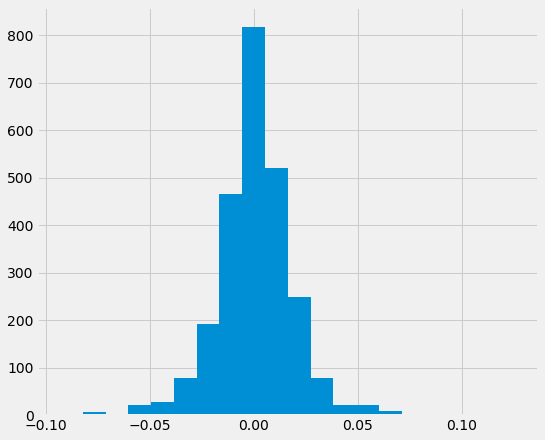

In [7]:
stock_df = pd.read_csv('stock_df.csv', index_col=index_col) # 'Date' for 1d, 'Datetime' for 60m
stock_df['percent change'].hist(bins=20)

In [8]:
stock_df['percent change'].quantile([0.84])

0.84    0.015604
Name: percent change, dtype: float64

In [9]:
perc = [x*0.01 for x in range(5,105, 5)]
perc

[0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.85,
 0.9,
 0.9500000000000001,
 1.0]

In [10]:
roc_lst = []
auc_lst = []
results_lst = []
perc = [x*0.01 for x in range(5,105, 5)]

for x in perc:
    ones, roc, auc, result = direction(interval = interval
                                       , history = history
                                       , perc_inc = perc_inc
                                       , symbol = symbol
                                       , perc_train = x
                                       , load_new = load_new
                                       , current = current
                                       , loc = loc
                                      )
    roc_lst.append(roc)
    auc_lst.append(auc)
    results_lst.append(result)

results_df = pd.DataFrame({'Percent': perc
                           , 'ROC': roc_lst
                           , 'AUC': auc_lst
                           , 'Result': results_lst
                          }
                         )

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [11]:
results_df

,Percent,ROC,AUC,Result
0,0.05,0.621894,0.597,Buy CRM on the 1d interval for 2.8% increase.
1,0.10,0.756988,0.781,Buy CRM on the 1d interval for 2.8% increase.
2,0.15,0.705745,0.733,Buy CRM on the 1d interval for 2.8% increase.
3,0.20,0.821429,0.800,Buy CRM on the 1d interval for 2.8% increase.
4,0.25,0.681677,0.739,Buy CRM on the 1d interval for 2.8% increase.
5,0.30,0.822981,0.839,Buy CRM on the 1d interval for 2.8% increase.
6,0.35,0.634317,0.739,Buy CRM on the 1d interval for 2.8% increase.
7,0.40,0.645186,0.647,Buy CRM on the 1d interval for 2.8% increase.
8,0.45,0.593944,0.639,Buy CRM on the 1d interval for 2.8% increase.
9,0.50,0.763975,0.748,Buy CRM on the 1d interval for 2.8% increase.


In [12]:
results_df.Result.value_counts()

Buy CRM on the 1d interval for 2.8% increase.    19
Sell or hold CRM on the 1d interval.              1
Name: Result, dtype: int64

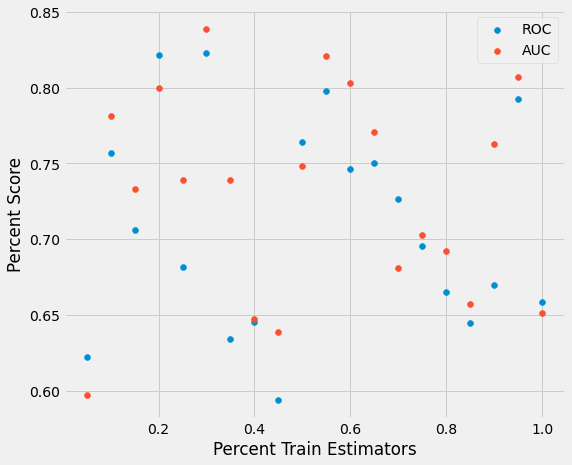

In [13]:
plt.scatter(results_df.Percent
            , results_df.ROC
            , label = 'ROC'
           )
plt.scatter(results_df.Percent
            , results_df.AUC
            , label = 'AUC'
           )
plt.xlabel('Percent Train Estimators')
plt.ylabel('Percent Score')
plt.legend();


In [14]:
results_df.loc[results_df.ROC == results_df.ROC.max()]

,Percent,ROC,AUC,Result
5,0.3,0.822981,0.839,Buy CRM on the 1d interval for 2.8% increase.


In [15]:
best_perc = results_df.loc[results_df.ROC == results_df.ROC.max()].Percent.iloc[0]
best_perc

0.3

In [16]:
ones, roc, auc, result = direction(interval = interval
                                   , history = history
                                   , perc_inc = 0.02
                                   , symbol = symbol
                                   , perc_train = best_perc
                                   , current = 1
                                  )
print(f'Positives: {ones}')
print(f'ROC Score: {round(roc, 2)}')
print(f'AUC Score: {round(auc, 2)}')
print(result)

[*********************100%***********************]  1 of 1 completed
Positives: 270
ROC Score: 0.65
AUC Score: 0.65
Buy CRM on the 1d interval for 2.0% increase.


In [17]:
stock_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,percent change,hl percent change,decision
Date,,,,,,,,,
2020-08-28,271.279999,275.750000,267.399994,271.100006,271.100006,28068000,-0.000663,-0.030281,0
2020-08-31,270.000000,274.709991,265.910004,272.649994,272.649994,16010100,0.009815,0.033094,0
2020-09-01,271.000000,281.929993,270.579987,281.250000,281.250000,13303200,0.037823,0.041947,1
2020-09-02,283.470001,284.500000,268.570007,276.690002,276.690002,12963800,-0.023918,-0.055993,0
2020-09-03,270.579987,271.750000,257.410004,265.010010,265.010010,13979200,-0.020585,-0.052769,0


### Thirty-One Calls

In [18]:
roc_scores = []
auc_scores = []
decisions = []
for _ in range(25):
    _, roc, auc, result = direction(interval = interval
                                    , history = history
                                    , perc_inc = perc_inc
                                    , symbol = symbol
                                    , perc_train = best_perc
                                    , load_new = load_new
                                    , current = current
                                    , loc = loc
                                   )
    roc_scores.append(roc)
    auc_scores.append(auc)
    decisions.append(result)

twenty_one_df = pd.DataFrame({'roc': roc_scores
                              , 'auc': auc_scores
                              , 'decision': decisions
                             })
print(f'Location: {loc}')
print(stock_df.iloc[loc])
twenty_one_df.decision.value_counts()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Buy CRM on the 1d interval for 2.8% increase.    23
Sell or hold CRM on the 1d interval.              2
Name: decision, dtype: int64

### Get pervious n predictions

In [19]:
# ''' 

# 95 Percentile
# BAC 1wk 7.16%, 1d 2.5%, 1hr 1%
# CRM 1d 2.76%, 1hr 1%
# IDEX 1d 10.8%, 1hr 4.15%
# IYW 1d 1.5%, 1hr 0.697%
# JEF 1d 2.5%, 1hr 1.1%
# NVAX 1d 6.46%, 1hr 3.15%
# QDEL 1d 3.53%, 1hr 
# TSLA 1d 4.3%, 1hr 1.66%
# VBIV 1d 7.99%, 1hr 4.05%
# VGT 1d 1.41% 1hr 0.686%
# VHT 1d 1.24%, 1hr 0.59%

# '''

# interval = '60m' # 60m or 1d
# history = '2y' # 2y for 60m, max for 1d
# perc_inc = 0.006 # 0.008 for 60m, 0.02 for 1d (IYW)
# symbol = 'BAC'
# perc_train = 0.25
# load_new = 0 # 0 for reuse, 1 for load new from server
# current = 0 # 0 for 2nd to last data point (once markets open), 1 for last data point (when market is closed)
# # loc = -169 # row for previous nth interval, -2 (once market open)
# n = 211 # num of pervious calls 

# def calls(n):
#     lst = []
#     for i in range(-n,0):
#         roc_scores = []
#         auc_scores = []
#         decisions = []
#         for _ in range(31):
#             _, roc, auc, result = direction(interval = interval
#                                             , history = history
#                                             , perc_inc = perc_inc
#                                             , symbol = symbol
#                                             , perc_train = best_perc
#                                             , load_new = load_new
#                                             , current = current
#                                             , loc = -i
#                                            )
#             roc_scores.append(roc)
#             auc_scores.append(auc)
#             decisions.append(result)

#         twenty_one_df = pd.DataFrame({'roc': roc_scores
#                                       , 'auc': auc_scores
#                                       , 'decision': decisions
#                                      })
        
#         lst.append(twenty_one_df.decision.value_counts().index[0])
#     return [x for x in range(-n,0)], lst

# nth, pred = calls(n)
# dict_calls = {'prev_nth': nth
#               , 'prediction': pred
#              }
# df_calls = pd.DataFrame(dict_calls)
# df_calls